# Final Project - CO2 Emissions Prediction


## Introduction
This project focuses on predicting CO2 emissions levels using a dataset of industrial machinery specifications and fuel consumption metrics. The objectives include:
- Performing Exploratory Data Analysis (EDA).
- Preparing the dataset for classification tasks.
- Training and evaluating various classification models.
- Building a regression model for predicting continuous CO2 emissions.
- Comparing model performances and providing insights.

---

In [1]:
# import all necessaries libraries
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix


## Exploratory Data Analysis (EDA)


### Goals
- Understand the data distribution.
- Identify missing values and outliers.
- Explore relationships between features and the target variables.

### Steps
1. Load and preview the dataset.
2. Summarize key statistics.
3. Visualize distributions and relationships using plots (e.g., histograms, scatterplots, heatmaps).

---

In [2]:
df_train_emission = pd.read_csv('train.csv')
df_test_emission = pd.read_csv('test.csv')

In [3]:
df_train_emission.head(5)

,Manufacturer,Machine Model,Machinery Category,Engine Capacity (L),Engine Cylinders,Transmission Type,Fuel Category,Fuel Consumption (Load Condition) (L/100 hr),Fuel Consumption (No-Load Condition) (L/100 hr),Average Fuel Consumption (L/100 hr),Average Fuel Efficiency (hrg),CO2 Emissions (g/hr),CO2 Emissions Level
0,Mercedes Industrial Solutions,AGE+,Mid-Sized Utility Machines,4.0,8,A9,Z,16.0,10.5,13.5,21,318,high
1,Bauer Machinery Works,38_E,Compact Utility Equipment,2.0,4,A8,Z,10.6,7.2,9.1,31,209,medium
2,Porsche Engineering Works,MCNO,Small Utility Vehicle,3.6,6,A7,Z,14.2,10.1,12.3,23,287,high
3,Toyota Heavy Machinery,TNRA,Standard Transport Machinery,4.0,6,AS5,X,14.8,11.8,13.5,21,310,high
4,Nissan Machinery Ltd.,FOTR,Light-Duty Transport Machinery,2.5,4,A5,X,13.7,10.7,12.3,23,290,high


In [4]:
df_train_emission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5908 entries, 0 to 5907
Data columns (total 13 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Manufacturer                                     5908 non-null   object 
 1   Machine Model                                    5908 non-null   object 
 2   Machinery Category                               5908 non-null   object 
 3   Engine Capacity (L)                              5908 non-null   float64
 4   Engine Cylinders                                 5908 non-null   int64  
 5   Transmission Type                                5908 non-null   object 
 6   Fuel Category                                    5908 non-null   object 
 7   Fuel Consumption (Load Condition) (L/100 hr)     5908 non-null   float64
 8   Fuel Consumption (No-Load Condition) (L/100 hr)  5908 non-null   float64
 9   Average Fuel Consumption (L/10

there are 5908 instances and all of them are filled with non-zero values. The data set is large enough to perform meaningful analyses. The characteristics ‘Manufacturer’, ‘Machine model’, ‘Machine category’, ‘Transmission type’, ‘Fuel category’ and ‘CO2 emission level’ are categorical characteristics, while all others are continuous characteristics.

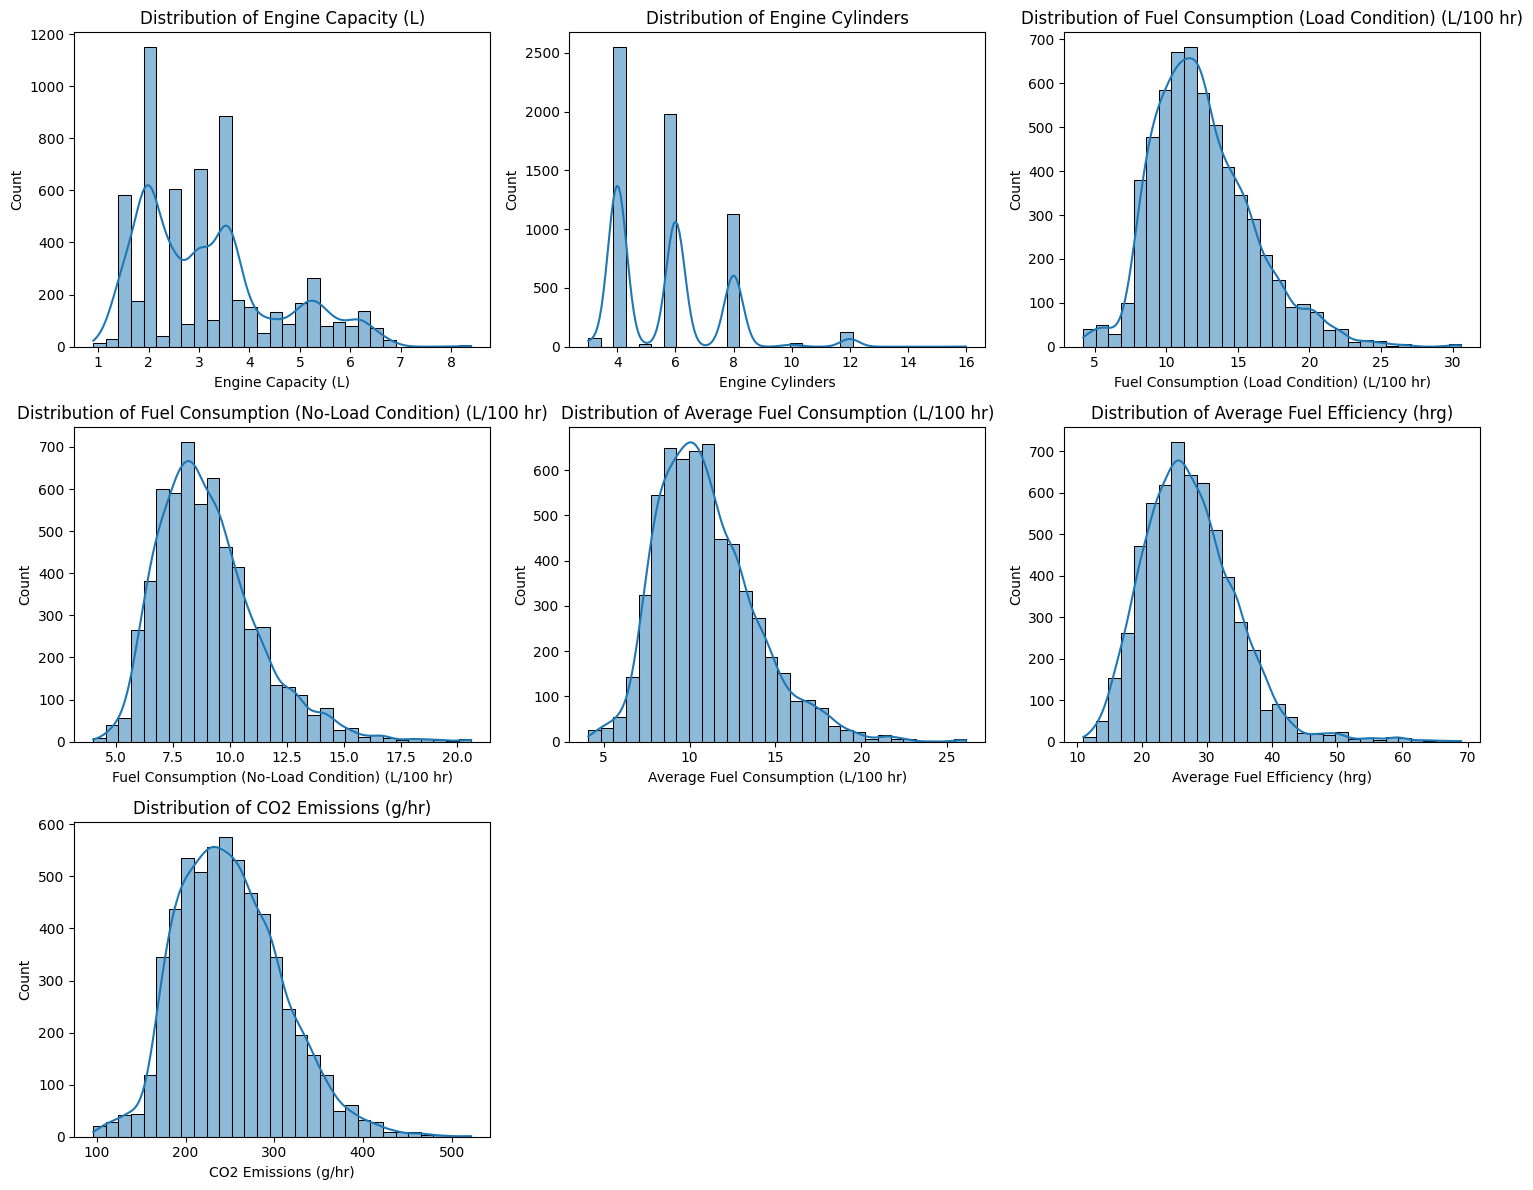

In [5]:
numerical_columns = df_train_emission.select_dtypes(include=['float64', 'int64']).columns

num_features = len(numerical_columns)
num_cols = 3 
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
axes = axes.flatten()  

for i, col in enumerate(numerical_columns):
    sns.histplot(df_train_emission[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribution of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()

From the histograms, we can see that the distribution is to the right and has a high kurtosis, but we can already see that it is constant in all distributions, so we probably cannot consider it an outlier. We also explore the distribution with a boxplot

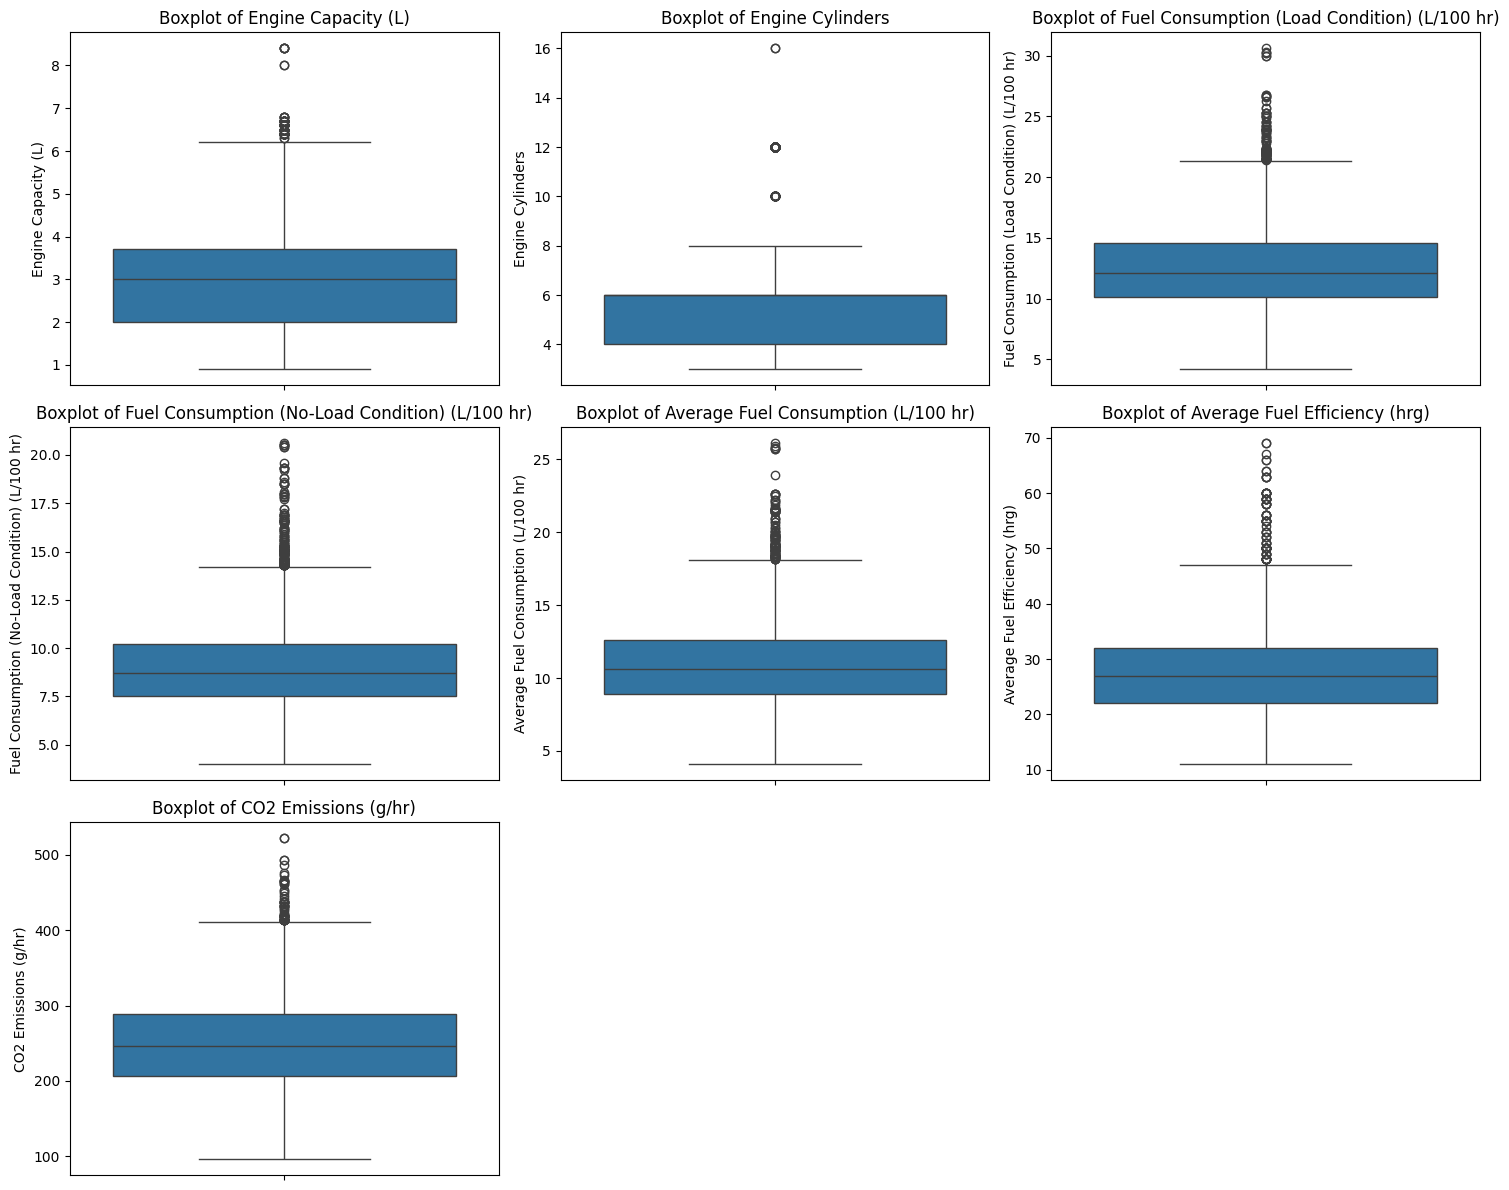

In [6]:
# box plot to highlight that the values that could be considered as outliers are actually similar in all distributions, which underlines the fact that indeed
# there are machines that are more efficient than others (a few with reliable values)

num_features = len(numerical_columns)
num_cols = 3  
num_rows = (num_features // num_cols) + (num_features % num_cols > 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
axes = axes.flatten()  

for i, col in enumerate(numerical_columns):
    sns.boxplot(y=df_train_emission[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  
plt.show()


The boxplots illustrate the numerical features of the dataset. While some points might be considered outliers, particularly in features like Fuel Consumption and Average Fuel Efficiency, these values are consistent across all distributions and represent valid observations. They highlight the presence of machines with higher or lower efficiency, which is typical for diverse machinery types. For this reason, these data points are not excluded but instead considered essential for capturing the variability in machine performance.

In [7]:
# looks for correlations
# Select only numeric columns for correlation calculation

corr_matrix = df_train_emission.select_dtypes(include=[np.number]).corr()
corr_matrix['CO2 Emissions (g/hr)'].sort_values(ascending=False)

CO2 Emissions (g/hr)                               1.000000
Fuel Consumption (Load Condition) (L/100 hr)       0.919646
Average Fuel Consumption (L/100 hr)                0.918044
Fuel Consumption (No-Load Condition) (L/100 hr)    0.883787
Engine Capacity (L)                                0.852074
Engine Cylinders                                   0.833544
Average Fuel Efficiency (hrg)                     -0.908135
Name: CO2 Emissions (g/hr), dtype: float64

There are many features with a high correlation to our target, which means we should get good models to predict it

In [8]:
# counts the different possible outputs of every features
categorical_columns = df_train_emission.select_dtypes(include='object').columns
for element in categorical_columns:
    print(f"unique values of {element}: {df_train_emission[element].nunique()}")

unique values of Manufacturer: 42
unique values of Machine Model: 999
unique values of Machinery Category: 16
unique values of Transmission Type: 27
unique values of Fuel Category: 5
unique values of CO2 Emissions Level: 4


categorical features are mainly divided into:
- features with few unique values and therefore easily encodable (one hot encoding)
- features with a medium number of unique values (one hot encoding becomes more expensive)
- features with a large number of unique values, so it is important to try to group them into subgroups in order not to make our dataset too complex

I will now iterate on each categorical feature, being careful to try and group features that I know have many different unique values

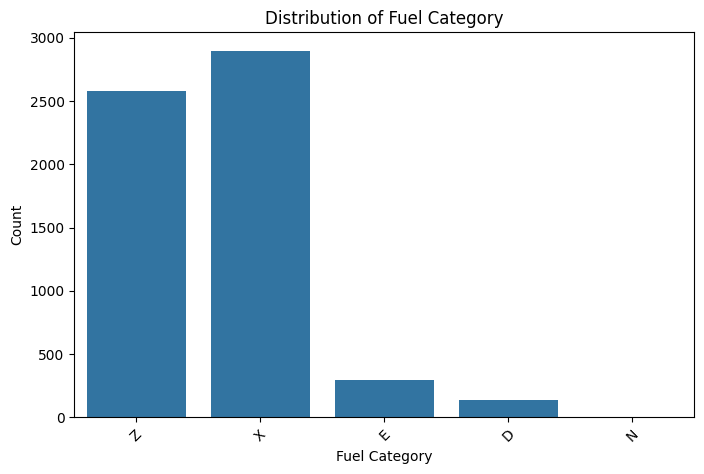

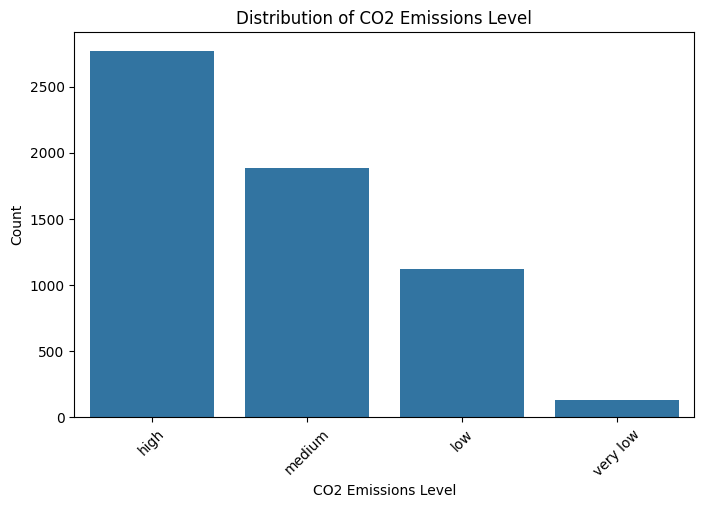

In [9]:
# Bar plot for features with few unique values
for feature in ['Fuel Category', 'CO2 Emissions Level']:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df_train_emission, x=feature)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

C:\Users\ms\AppData\Local\Temp\ipykernel_29428\394326279.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=value_counts.index, x=value_counts.values, palette="viridis")


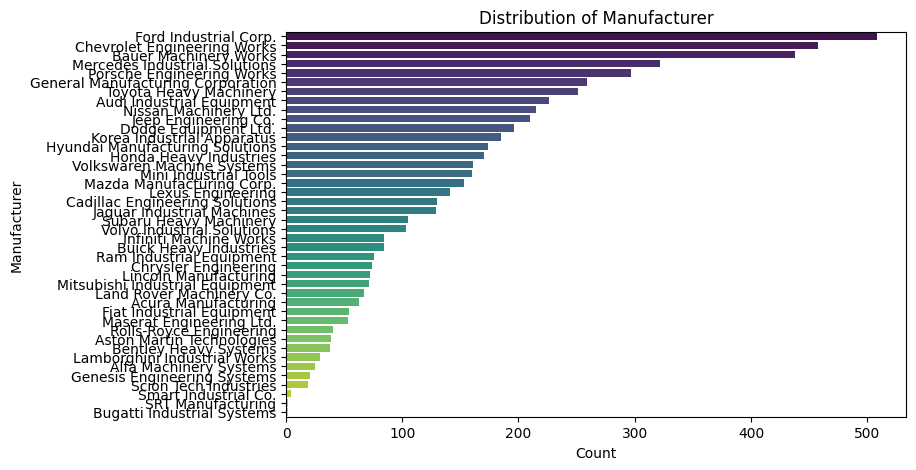

C:\Users\ms\AppData\Local\Temp\ipykernel_29428\394326279.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=value_counts.index, x=value_counts.values, palette="viridis")


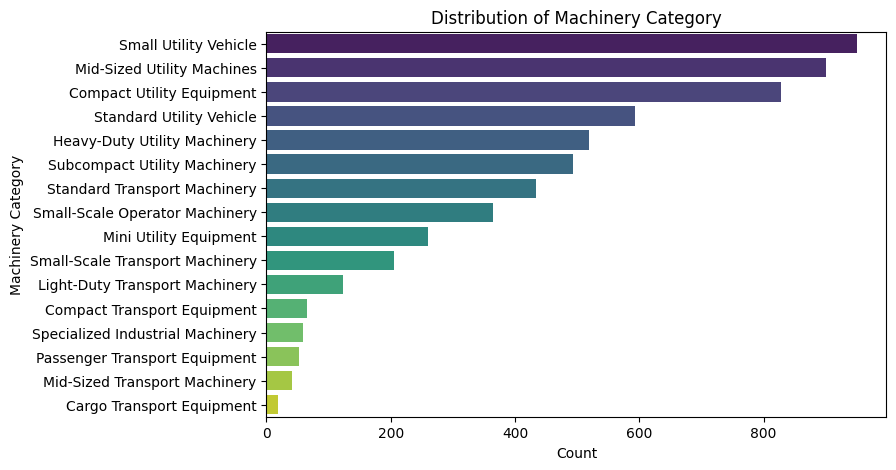

C:\Users\ms\AppData\Local\Temp\ipykernel_29428\394326279.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=value_counts.index, x=value_counts.values, palette="viridis")


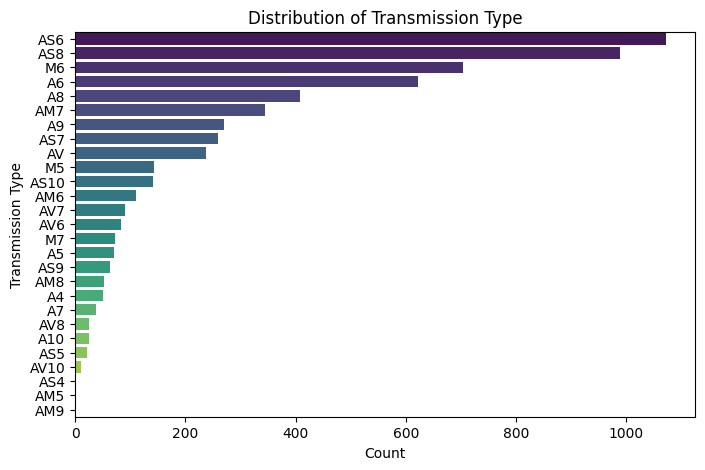

In [10]:
# Horizontal bar plot for features with moderate unique values
for feature in ['Manufacturer', 'Machinery Category', 'Transmission Type']:
    plt.figure(figsize=(8, 5))
    value_counts = df_train_emission[feature].value_counts()
    sns.barplot(y=value_counts.index, x=value_counts.values, palette="viridis")
    plt.title(f"Distribution of {feature}")
    plt.xlabel("Count")
    plt.ylabel(feature)
    plt.show()

In [11]:
# Iterate over selected categorical features to analyze low-frequency categories
for feature in ['Manufacturer', 'Machinery Category', 'Transmission Type']:
    # Count occurrences of each unique value in the feature
    value_counts = df_train_emission[feature].value_counts()

    # Filter categories with occurrences less than or equal to 50
    low_frequency_values = value_counts[value_counts <= 50]
    
    # Print details for the feature
    print(f"\nLow-frequency values in '{feature}':")
    print(low_frequency_values)
    print(f"\nNumber of unique values with <= 50 occurrences: {len(low_frequency_values)}")


Low-frequency values in 'Manufacturer':
Manufacturer
Rolls-Royce Engineering         40
Aston Martin Technologies       39
Bentley Heavy Systems           38
Lamborghini Industrial Works    29
Alfa Machinery Systems          25
Genesis Engineering Systems     21
Scion Tech Industries           19
Smart Industrial Co.             4
SRT Manufacturing                2
Bugatti Industrial Systems       2
Name: count, dtype: int64

Number of unique values with <= 50 occurrences: 10

Low-frequency values in 'Machinery Category':
Machinery Category
Mid-Sized Transport Machinery    41
Cargo Transport Equipment        18
Name: count, dtype: int64

Number of unique values with <= 50 occurrences: 2

Low-frequency values in 'Transmission Type':
Transmission Type
A4      50
A7      37
AV8     26
A10     25
AS5     22
AV10    11
AS4      2
AM5      2
AM9      2
Name: count, dtype: int64

Number of unique values with <= 50 occurrences: 9


C:\Users\ms\AppData\Local\Temp\ipykernel_29428\2304078537.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=value_counts.index, x=value_counts.values, palette="viridis")


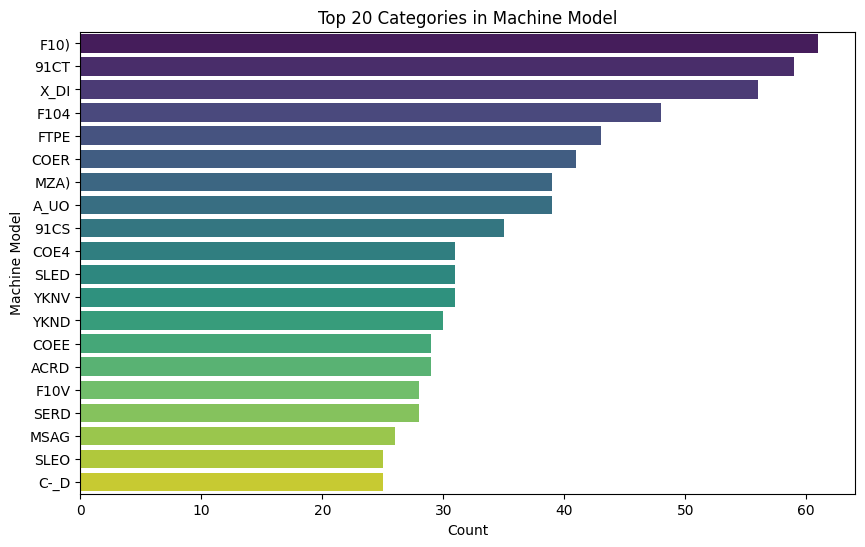

In [12]:
# Truncated bar plot for features with too many unique values
feature_top_20  = 'Machine Model'
value_counts = df_train_emission[feature_top_20].value_counts().head(20)  # Top 20 only
plt.figure(figsize=(10, 6))
sns.barplot(y=value_counts.index, x=value_counts.values, palette="viridis")
plt.title(f"Top 20 Categories in {feature_top_20}")
plt.xlabel("Count")
plt.ylabel(feature_top_20)
plt.show()


In [13]:
# Explore the feature 'Machine Model'
feature = 'Machine Model'

value_counts = df_train_emission[feature].value_counts()

low_frequency_values = value_counts[value_counts <= 50]
    
# Visualizzare il risultato
print(f"\nUnique value with low frequency '{feature}':")
print(low_frequency_values)
print(f"\nnumbers of values with frequence <= 50: {len(low_frequency_values)}")


Unique value with low frequency 'Machine Model':
Machine Model
F104    48
FTPE    43
COER    41
MZA)    39
A_UO    39
        ..
C5VD     1
ECRG     1
FPCD     1
Q_YD     1
HRCE     1
Name: count, Length: 996, dtype: int64

numbers of values with frequence <= 50: 996


As I have seen through the EDA of categorical variables, we have many ‘rare’ counts for each category, which means I have to manage and eliminate them because otherwise the model will be too complex (it will have too many categories after econding) and will be overfit.

## Data Preparation

### Goals
- Handle missing values and outliers.
- Encode categorical features.
- Normalize/scale numerical features.
- Split the data into training and test sets.

---

In [14]:
# handling the duplicates
duplicates = df_train_emission.duplicated().sum()
print(f'In the dataset there are {duplicates} data points duplicated')

In the dataset there are 1070 data points duplicated


In [15]:
# drop all the duplicates
df_train_emission = df_train_emission.drop_duplicates().reset_index(drop=True)

#### split the dataset in order to create also a validation set

In [16]:
from sklearn.model_selection import train_test_split
# split the dataset in order to create also a validation set

X_train = df_train_emission.drop(columns=['CO2 Emissions Level', 'CO2 Emissions (g/hr)'])
X_test = df_test_emission.drop(columns=['CO2 Emissions Level', 'CO2 Emissions (g/hr)'])

y_train = df_train_emission['CO2 Emissions Level']
y_test = df_test_emission['CO2 Emissions Level']


# I am adding the stratify to the train_test_split beacuse the classes are imbalanced
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)  

In [17]:
print("Shape of the dataset")
print(f"Train set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Validation set: X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Test set: X_test={X_test.shape}, y_test={y_test.shape}")

Shape of the dataset
Train set: X_train=(3870, 11), y_train=(3870,)
Validation set: X_val=(968, 11), y_val=(968,)
Test set: X_test=(1477, 11), y_test=(1477,)


Since we are working with different models that should receive different types of data, I am creating a copy of the split sets that will be used with the model that does not need scaled and transformed data (such as the decision tree, random forest, etc.) instead of the softmax regression and the regression model that need scaled and transformed data.

In addition, I created a validation set for both types of datasets to evaluate the performance of the model during training, separate from the training and test datasets.

In [18]:
X_train_lin = X_train.copy(deep=True)
X_test_lin = X_test.copy(deep=True)

X_val_lin = X_val.copy(deep=True)
y_val_lin = y_val.copy(deep=True)

# Usa i valori numerici del target 'CO2 Emissions (g/hr)' per i modelli lineari
y_train_lin = df_train_emission.loc[X_train.index, 'CO2 Emissions (g/hr)']
y_test_lin = df_test_emission.loc[X_test.index, 'CO2 Emissions (g/hr)']
y_val_lin = df_train_emission.loc[X_val.index, 'CO2 Emissions (g/hr)']

#### encoding of the categorical feature for all the models

In [19]:
def handle_rare_categories(train_df, test_df, val_df, column, threshold):
    """
    Replace categories with frequency below a threshold with 'Rare'.
    The logic is based only on the training dataset.
    """
    value_counts = train_df[column].value_counts()
    rare_values = value_counts[value_counts < threshold].index

    # Replace rare values with 'Rare' in all datasets
    train_df[column] = train_df[column].where(~train_df[column].isin(rare_values), 'Rare')
    test_df[column] = test_df[column].where(~test_df[column].isin(rare_values), 'Rare')
    val_df[column] = val_df[column].where(~val_df[column].isin(rare_values), 'Rare')
    
    return train_df, test_df, val_df

In [20]:
from sklearn.preprocessing import LabelEncoder

def apply_label_encoding_with_rare(train_df, test_df, val_df, column):

    label_encoder = LabelEncoder()
    
    # Replace unseen values with 'Rare' in test and validation datasets
    rare_category = 'Rare'

    # Ensure 'Rare' exists in the training data
    train_df[column] = train_df[column].fillna(rare_category)
    if rare_category not in train_df[column].values:
        train_df[column] = train_df[column].astype(str)  # Ensure all values are strings
        train_df = pd.concat([train_df, pd.DataFrame({column: [rare_category]})]).iloc[:-1]
    
    # Fit the LabelEncoder only on the training data
    label_encoder.fit(train_df[column])
    
    # Replace unseen values with 'Rare' in test and validation datasets
    test_df[column] = test_df[column].fillna(rare_category).apply(
        lambda x: x if x in label_encoder.classes_ else rare_category
    )
    val_df[column] = val_df[column].fillna(rare_category).apply(
        lambda x: x if x in label_encoder.classes_ else rare_category
    )
    
    # Transform all datasets
    train_df[f"{column}_encoded"] = label_encoder.transform(train_df[column])
    test_df[f"{column}_encoded"] = label_encoder.transform(test_df[column])
    val_df[f"{column}_encoded"] = label_encoder.transform(val_df[column])
    
    # Drop the original column
    train_df.drop(columns=[column], inplace=True)
    test_df.drop(columns=[column], inplace=True)
    val_df.drop(columns=[column], inplace=True)
    
    # Rename the encoded column back to the original column name
    train_df.rename(columns={f"{column}_encoded": column}, inplace=True)
    test_df.rename(columns={f"{column}_encoded": column}, inplace=True)
    val_df.rename(columns={f"{column}_encoded": column}, inplace=True)
    
    return train_df, test_df, val_df

first I encode the dataset for the non linear models:


In [21]:
from sklearn.preprocessing import OneHotEncoder

# One-Hot Encoding for nominal categorical features: 'Machinery Category', 'Transmission Type', 'Fuel Category'
encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[['Machinery Category', 'Transmission Type', 'Fuel Category']])
X_test_encoded = encoder.transform(X_test[['Machinery Category', 'Transmission Type', 'Fuel Category']])
X_val_encoded = encoder.transform(X_val[['Machinery Category', 'Transmission Type', 'Fuel Category']])

feature_names = encoder.get_feature_names_out(['Machinery Category', 'Transmission Type', 'Fuel Category'])

# Convert encoded output to DataFrame with named columns
X_train_encoded = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)
X_val_encoded = pd.DataFrame(X_val_encoded, columns=feature_names, index=X_val.index)

# Concatenate 
X_train = pd.concat([X_train, X_train_encoded], axis=1)
X_test = pd.concat([X_test, X_test_encoded], axis=1)
X_val = pd.concat([X_val, X_val_encoded], axis=1)

# Drop the original columns after encoding
X_train.drop(columns=['Machinery Category', 'Transmission Type', 'Fuel Category'], inplace=True)
X_test.drop(columns=['Machinery Category', 'Transmission Type', 'Fuel Category'], inplace=True)
X_val.drop(columns=['Machinery Category', 'Transmission Type', 'Fuel Category'], inplace=True)

In [22]:
# Define the column to process and the frequency threshold
column_name = 'Manufacturer'
threshold = 10

# Step 1: Handle rare categories
X_train, X_test, X_val = handle_rare_categories(X_train, X_test, X_val, column_name, threshold)

# Step 2: Apply label encoding
X_train, X_test, X_val = apply_label_encoding_with_rare(X_train, X_test, X_val, column_name)

In [23]:
# Define the column to process and the frequency threshold
column_name = 'Machine Model'
threshold = 50

# Step 1: Handle rare categories
X_train, X_test, X_val = handle_rare_categories(X_train, X_test, X_val, column_name, threshold)

# Step 2: Apply label encoding
X_train, X_test, X_val = apply_label_encoding_with_rare(X_train, X_test, X_val, column_name)

now I'm going to encode the dataset for the linear models

In [24]:
# Apply rare category handling for 'Manufacturer'
X_train_lin, X_test_lin, X_val_lin = handle_rare_categories(X_train_lin, X_test_lin, X_val_lin, 'Manufacturer', 50)

# Apply rare category handling for 'Machine Model'
X_train_lin, X_test_lin, X_val_lin = handle_rare_categories(X_train_lin, X_test_lin, X_val_lin, 'Machine Model', 10)

# Step 2: One-Hot Encoding for all nominal categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit encoder on training data
X_train_encoded = encoder.fit_transform(X_train_lin[['Manufacturer', 'Machine Model', 'Machinery Category', 'Transmission Type', 'Fuel Category']])

# Transform test and validation data
X_test_encoded = encoder.transform(X_test_lin[['Manufacturer', 'Machine Model', 'Machinery Category', 'Transmission Type', 'Fuel Category']])
X_val_encoded = encoder.transform(X_val_lin[['Manufacturer', 'Machine Model', 'Machinery Category', 'Transmission Type', 'Fuel Category']])

# Convert encoded arrays back to DataFrames with named columns
feature_names = encoder.get_feature_names_out(['Manufacturer', 'Machine Model', 'Machinery Category', 'Transmission Type', 'Fuel Category'])
X_train_encoded = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train_lin.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test_lin.index)
X_val_encoded = pd.DataFrame(X_val_encoded, columns=feature_names, index=X_val_lin.index)

# Step 3: Concatenate encoded features back to the datasets
X_train_lin = pd.concat([X_train_lin.drop(columns=['Manufacturer', 'Machine Model', 'Machinery Category', 'Transmission Type', 'Fuel Category']), X_train_encoded], axis=1)
X_test_lin = pd.concat([X_test_lin.drop(columns=['Manufacturer', 'Machine Model', 'Machinery Category', 'Transmission Type', 'Fuel Category']), X_test_encoded], axis=1)
X_val_lin = pd.concat([X_val_lin.drop(columns=['Manufacturer', 'Machine Model', 'Machinery Category', 'Transmission Type', 'Fuel Category']), X_val_encoded], axis=1)

#### scale the data only for the linear models (it means all the set named "lin")

The standard scaling is applied because the selected features follow a nearly normal distribution, making StandardScaler appropriate. This ensures that all values are scaled consistently without removing or modifying data, as I do not consider them outliers.

In [25]:
from sklearn.preprocessing import StandardScaler

# Instantiate the scalers
standard_scaler = StandardScaler()

# Columns for each scaling method based on the distribution analysis
standard_scaling_columns = [
    'Fuel Consumption (Load Condition) (L/100 hr)',
    'Fuel Consumption (No-Load Condition) (L/100 hr)',
    'Average Fuel Consumption (L/100 hr)',
    'Average Fuel Efficiency (hrg)'
    ]

# Apply scaling to numerical features
X_train_lin[standard_scaling_columns] = standard_scaler.fit_transform(X_train_lin[standard_scaling_columns])
X_test_lin[standard_scaling_columns] = standard_scaler.transform(X_test_lin[standard_scaling_columns])
X_val_lin[standard_scaling_columns] = standard_scaler.transform(X_val_lin[standard_scaling_columns])

#### perform feature transformation on the dataset for the linear model

I also decided to binning these two features 'Engine Capacity (L)', 'Engine Cylinders' because I wanted to reduce the complexity of numerical data. and also 
Capturing patterns or trends in the data (e.g. the two distributions have more peaks)

In [26]:
# Features for binning
binning_columns = ['Engine Capacity (L)', 'Engine Cylinders']
# Apply binning to 'Engine Capacity (L)' with equal-frequency bins
X_train_lin['Engine_Capacity_Binned'] = pd.qcut(X_train_lin['Engine Capacity (L)'], q=4, labels=False)
X_test_lin['Engine_Capacity_Binned'] = pd.qcut(X_test_lin['Engine Capacity (L)'], q=4, labels=False)
X_val_lin['Engine_Capacity_Binned'] = pd.qcut(X_val_lin['Engine Capacity (L)'], q=4, labels=False)

# Apply binning to 'Engine Cylinders' using predefined bin edges from training set
bin_edges = pd.cut(X_train_lin['Engine Cylinders'], bins=4, retbins=True)[1]  # Retrieve bin edges
X_train_lin['Engine_Cylinders_Binned'] = pd.cut(X_train_lin['Engine Cylinders'], bins=bin_edges, labels=False, include_lowest=True)
X_test_lin['Engine_Cylinders_Binned'] = pd.cut(X_test_lin['Engine Cylinders'], bins=bin_edges, labels=False, include_lowest=True)
X_val_lin['Engine_Cylinders_Binned'] = pd.cut(X_val_lin['Engine Cylinders'], bins=bin_edges, labels=False, include_lowest=True)

# Drop original columns if not needed
X_train_lin.drop(columns=['Engine Capacity (L)', 'Engine Cylinders'], inplace=True)
X_test_lin.drop(columns=['Engine Capacity (L)', 'Engine Cylinders'], inplace=True)
X_val_lin.drop(columns=['Engine Capacity (L)', 'Engine Cylinders'], inplace=True)

#### reduce the dataset dimensionality for the linear model

I also opted for a reduction of the dataset to try to reduce the complexity of the data as it had many variables. 

In [27]:
# Print the size of the datasets for non-linear models
print("Non-linear Models:")
print(f"X_train size: {X_train.shape}")
print(f"X_test size: {X_test.shape}")
print(f"X_val size: {X_val.shape}")
print(f"y_train size: {y_train.shape}")
print(f"y_test size: {y_test.shape}")
print(f"y_val size: {y_val.shape}")

print("\n" + "="*40 + "\n")

# Print the size of the datasets for linear models
print("Linear Models:")
print(f"X_train_lin size: {X_train_lin.shape}")
print(f"X_test_lin size: {X_test_lin.shape}")
print(f"X_val_lin size: {X_val_lin.shape}")
print(f"y_train_lin size: {y_train_lin.shape}")
print(f"y_test_lin size: {y_test_lin.shape}")
print(f"y_val_lin size: {y_val_lin.shape}")


Non-linear Models:
X_train size: (3870, 55)
X_test size: (1477, 55)
X_val size: (968, 55)
y_train size: (3870,)
y_test size: (1477,)
y_val size: (968,)


Linear Models:
X_train_lin size: (3870, 167)
X_test_lin size: (1477, 167)
X_val_lin size: (968, 167)
y_train_lin size: (3870,)
y_test_lin size: (1477,)
y_val_lin size: (968,)


Initialising a feature selection with the ANOVA test

In [28]:
from sklearn.feature_selection import f_regression
import pandas as pd

# Perform ANOVA F-test and get F-values and p-values
f_values, p_values = f_regression(X_train_lin, y_train_lin)

# Create DataFrame to store feature names and p-values
anova_results = pd.DataFrame({'Feature': X_train_lin.columns, 'F-value': f_values, 'p-value': p_values})

# Set significance threshold (e.g., 0.05)
significance_threshold = 0.05

# Select features with p-values below the threshold
anova_selected_features = anova_results[anova_results['p-value'] < significance_threshold]['Feature'].tolist()
print("ANOVA-selected features:", anova_selected_features)


ANOVA-selected features: ['Fuel Consumption (Load Condition) (L/100 hr)', 'Fuel Consumption (No-Load Condition) (L/100 hr)', 'Average Fuel Consumption (L/100 hr)', 'Average Fuel Efficiency (hrg)', 'Manufacturer_Buick Heavy Industries', 'Manufacturer_Cadillac Engineering Solutions', 'Manufacturer_Chevrolet Engineering Works', 'Manufacturer_Dodge Equipment Ltd.', 'Manufacturer_Ford Industrial Corp.', 'Manufacturer_General Manufacturing Corporation', 'Manufacturer_Honda Heavy Industries', 'Manufacturer_Hyundai Manufacturing Solutions', 'Manufacturer_Jaguar Industrial Machines', 'Manufacturer_Korea Industrial Apparatus', 'Manufacturer_Mazda Manufacturing Corp.', 'Manufacturer_Mercedes Industrial Solutions', 'Manufacturer_Mini Industrial Tools', 'Manufacturer_Nissan Machinery Ltd.', 'Manufacturer_Porsche Engineering Works', 'Manufacturer_Rare', 'Manufacturer_Subaru Heavy Machinery', 'Manufacturer_Toyota Heavy Machinery', 'Manufacturer_Volkswaren Machine Systems', 'Manufacturer_Volvo Industr

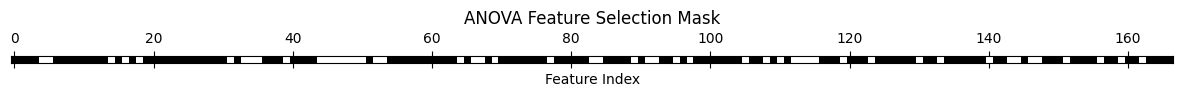

In [29]:
import matplotlib.pyplot as plt

# ANOVA selection mask
mask_anova = np.array([feature in anova_selected_features for feature in X_train_lin.columns])

plt.figure(figsize=(15, 2))
plt.matshow(mask_anova.reshape(1, -1), cmap='gray_r', fignum=1)
plt.title("ANOVA Feature Selection Mask")
plt.xlabel("Feature Index")
plt.yticks([])  
plt.show()

as it still selects too many features and also for datasets with many features it can be difficult, I decided to use a model based feature selection

In [30]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

# Initialize SelectFromModel with RandomForestRegressor
select_rf = SelectFromModel(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    threshold="median"
)

# Fit the model to select features
select_rf.fit(X_train_lin, y_train_lin)

# Get the mask of selected features and their names
mask_rf = select_rf.get_support()
rf_selected_features = X_train_lin.columns[mask_rf]

# Print the selected features
print("Model-based Random Forest selected features:", rf_selected_features)

# Reduce the dataset to the selected features
X_train_lin_reduced = X_train_lin[rf_selected_features]
X_test_lin_reduced = X_test_lin[rf_selected_features]
X_val_lin_reduced = X_val_lin[rf_selected_features]

# Print new shapes of the reduced datasets
print("Reduced X_train_lin shape:", X_train_lin_reduced.shape)
print("Reduced X_test_lin shape:", X_test_lin_reduced.shape)
print("Reduced X_val_lin shape:", X_val_lin_reduced.shape)

Model-based Random Forest selected features: Index(['Fuel Consumption (Load Condition) (L/100 hr)',
       'Fuel Consumption (No-Load Condition) (L/100 hr)',
       'Average Fuel Consumption (L/100 hr)', 'Average Fuel Efficiency (hrg)',
       'Manufacturer_Audi Industrial Equipment',
       'Manufacturer_Bauer Machinery Works',
       'Manufacturer_Buick Heavy Industries',
       'Manufacturer_Cadillac Engineering Solutions',
       'Manufacturer_Chevrolet Engineering Works',
       'Manufacturer_Dodge Equipment Ltd.',
       'Manufacturer_Ford Industrial Corp.',
       'Manufacturer_General Manufacturing Corporation',
       'Manufacturer_Honda Heavy Industries',
       'Manufacturer_Hyundai Manufacturing Solutions',
       'Manufacturer_Infiniti Machine Works',
       'Manufacturer_Jaguar Industrial Machines',
       'Manufacturer_Jeep Engineering Co.',
       'Manufacturer_Korea Industrial Apparatus',
       'Manufacturer_Lexus Engineering',
       'Manufacturer_Mazda Manufacturing

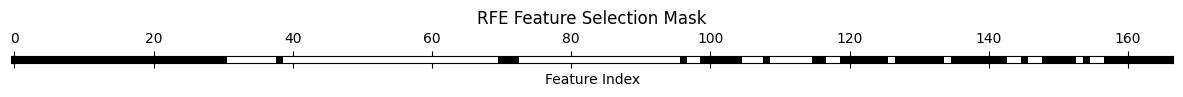

In [31]:
# Model base selection mask
mask_rfe = np.array([feature in rf_selected_features for feature in X_train_lin.columns])

plt.figure(figsize=(15, 2))
plt.matshow(mask_rfe.reshape(1, -1), cmap='gray_r', fignum=1)
plt.title("RFE Feature Selection Mask")
plt.xlabel("Feature Index")
plt.yticks([])  
plt.show()

In [32]:
# reduced dataset with selected feature
X_train_lin = X_train_lin[rf_selected_features]
X_test_lin = X_test_lin[rf_selected_features]
X_val_lin = X_val_lin[rf_selected_features]

# controlling the shape
print(f"X_train_lin_reduced shape: {X_train_lin.shape}")
print(f"X_test_lin_reduced shape: {X_test_lin.shape}")
print(f"X_val_lin_reduced shape: {X_val_lin.shape}")


X_train_lin_reduced shape: (3870, 84)
X_test_lin_reduced shape: (1477, 84)
X_val_lin_reduced shape: (968, 84)


as expected, the RFE Feature selection selected fewer features even though this resulted in a higher computational cost

#### reduce the dimensionality of the dataset for the non linear-model

In [33]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier to compute feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Select top features (e.g., top 25)
top_features = feature_importances.head(25).index.tolist()
print("Top 25 features:", top_features)

# Reduce the dataset to top features
X_train = X_train[top_features]
X_test = X_test[top_features]
X_val = X_val[top_features]

# Check the shape of the reduced datasets
print(f"X_train_reduced shape: {X_train.shape}")
print(f"X_test_reduced shape: {X_test.shape}")
print(f"X_val_reduced shape: {X_val.shape}")


Top 25 features: ['Average Fuel Consumption (L/100 hr)', 'Average Fuel Efficiency (hrg)', 'Fuel Consumption (Load Condition) (L/100 hr)', 'Fuel Consumption (No-Load Condition) (L/100 hr)', 'Engine Capacity (L)', 'Engine Cylinders', 'Manufacturer', 'Machinery Category_Standard Transport Machinery', 'Fuel Category_X', 'Machinery Category_Standard Utility Vehicle', 'Fuel Category_E', 'Fuel Category_D', 'Fuel Category_Z', 'Machinery Category_Small Utility Vehicle', 'Machinery Category_Compact Utility Equipment', 'Machinery Category_Mid-Sized Utility Machines', 'Transmission Type_AV', 'Machinery Category_Light-Duty Transport Machinery', 'Transmission Type_A6', 'Transmission Type_AS8', 'Transmission Type_A9', 'Machinery Category_Heavy-Duty Utility Machinery', 'Transmission Type_A8', 'Transmission Type_AS6', 'Transmission Type_M6']
X_train_reduced shape: (3870, 25)
X_test_reduced shape: (1477, 25)
X_val_reduced shape: (968, 25)


## Model Implementation

### Softmax Regression
- Regularization: Apply L2 regularization and tune hyperparameter `C` using grid search.
- Evaluate model performance with classification metrics (e.g., accuracy, F1-score).


In [34]:
def plot_confusion_matrix(classifier, y_test, y_pred):
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                                  display_labels=classifier.classes_)
    confusion_matrix_display.plot()

In [35]:
from sklearn.linear_model import LogisticRegression


# Define the Softmax Regression model
softmax_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', max_iter=5000)

# Define the grid of hyperparameters
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Use GridSearchCV for hyperparameter tuning
softmax = GridSearchCV(estimator=softmax_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

# Fit the model with grid search
softmax.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


c:\Users\ms\Desktop\SUPSI\supervised_learning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=5000,
                                          multi_class='multinomial'),
             n_jobs=-1, param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy', verbose=1)

In [36]:
print("Tuned Logistic Regression Parameters: {}".format(softmax.best_params_))
print("Best score: {:.2f}".format(softmax.best_score_))

Tuned Logistic Regression Parameters: {'C': 10}
Best score: 0.97


In [37]:
best_softmax_model = softmax.best_estimator_

# Synchronize features between training and testing
if hasattr(best_softmax_model, 'feature_names_in_'):
    X_test_aligned = X_test[best_softmax_model.feature_names_in_]
else:
    X_test_aligned = X_test  # If the attribute does not exist, assume features are aligned

# Predict on the test set
y_test_pred = best_softmax_model.predict(X_test_aligned)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))


Classification Report:
              precision    recall  f1-score   support

        high       0.98      0.99      0.98       694
         low       0.96      0.95      0.96       279
      medium       0.95      0.96      0.96       472
    very low       1.00      0.84      0.92        32

    accuracy                           0.97      1477
   macro avg       0.97      0.94      0.95      1477
weighted avg       0.97      0.97      0.97      1477



This Softmax model performs very well, with an overall accuracy of 97%. It correctly identifies “high,” “low,” and “medium” classes the vast majority of the time, with high precision and recall scores. The only slight weakness is in the “very low” class, where the model perfectly identifies it whenever it predicts “very low” (100% precision), but sometimes misses a few real “very low” cases (84% recall). Despite this, the overall results show that the model is highly accurate and reliable.

Accuracy Score: 96.89%


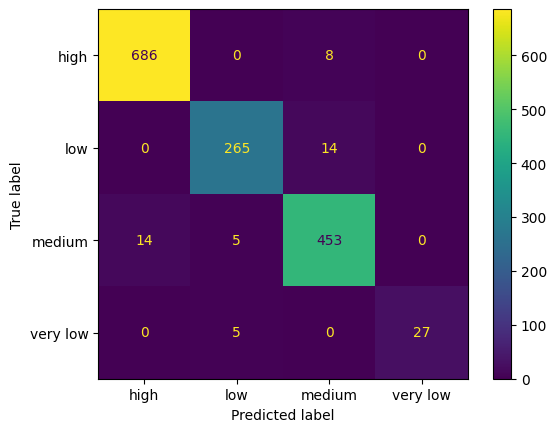

In [38]:
plot_confusion_matrix(best_softmax_model, y_test, y_test_pred)

The confusion matrix shows the model does a great job distinguishing among the four classes. Most “high,” “low,” and “medium” samples are correctly labeled, with only a few mix-ups (e.g., “low” vs. “very low,” “high” vs. “medium”). Overall, the model makes very few errors, confirming its strong performance.

### Decision Tree
- Identify and tune critical hyperparameters (e.g., max depth, min samples split).
- Discuss the impact of tuning on the model's performance.

In [39]:
from sklearn.tree import DecisionTreeClassifier

unconstraint_tree = DecisionTreeClassifier(random_state=0)
unconstraint_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [40]:
print("Accuracy on training set: {:.3f}".format(unconstraint_tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(unconstraint_tree.score(X_test, y_test)))

Accuracy on training set: 0.996
Accuracy on test set: 0.980


The decision tree already performs well without any parameters selected, but it is good to set the hyperparameters anyway to prevent it from overfitting

In [41]:
# Define the hyperparameters grid
params = {'max_depth': list(range(2, 50)), 'criterion': ['gini','entropy']}
DT_classifier_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1, verbose=1, cv=3)

DT_classifier_cv.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                       24, 25, 26, 27, 28, 29, 30, 31, ...]},
             verbose=1)

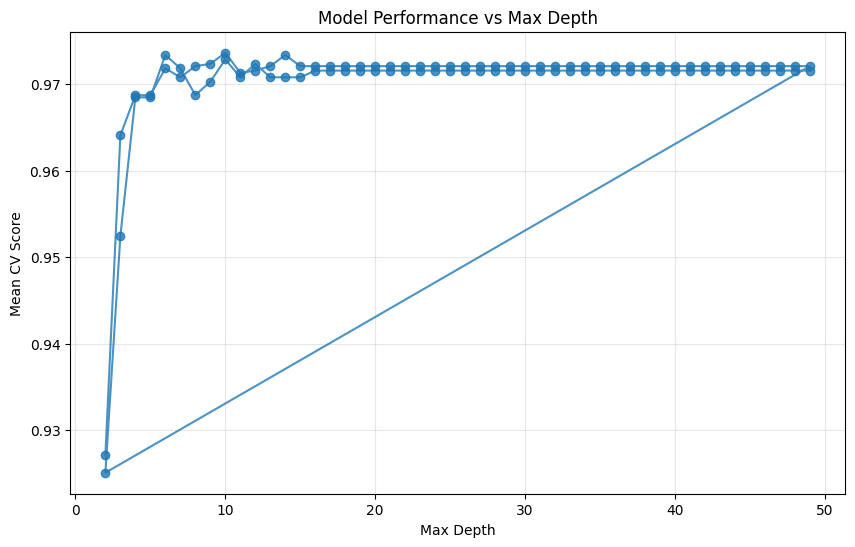

In [42]:
results = DT_classifier_cv.cv_results_

mean_test_scores = results['mean_test_score']
params = results['param_max_depth'].data  #max_depth

params = np.array(params, dtype=int)
mean_test_scores = np.array(mean_test_scores)

# plot the graph
plt.figure(figsize=(10, 6))
plt.plot(params, mean_test_scores, marker='o', linestyle='-', alpha=0.8)
plt.xlabel('Max Depth')
plt.ylabel('Mean CV Score')
plt.title('Model Performance vs Max Depth')
plt.grid(alpha=0.3)
plt.show()


The graph shows how the model’s mean cross-validation score changes with different max depths. Performance quickly rises and settles around 0.97 when max depth is between 5 and 10. Beyond that, increasing max depth doesn’t bring much improvement, indicating the model has already reached its optimal performance.

In [43]:
print(f'Selected parameters: {DT_classifier_cv.best_params_}')

Selected parameters: {'criterion': 'gini', 'max_depth': 10}


In [44]:
dt_predictions = DT_classifier_cv.predict(X_test)
print(classification_report(y_test, dt_predictions))

              precision    recall  f1-score   support

        high       0.99      0.99      0.99       694
         low       0.97      0.97      0.97       279
      medium       0.97      0.97      0.97       472
    very low       1.00      0.91      0.95        32

    accuracy                           0.98      1477
   macro avg       0.98      0.96      0.97      1477
weighted avg       0.98      0.98      0.98      1477



The classification report shows an overall accuracy of 0.98, which is excellent. The “high,” “low,” and “medium” classes all have very high precision and recall (mostly above 0.97). The “very low” class also performs well, with a perfect precision of 1.00 and a slightly lower recall of 0.91. Overall, the model demonstrates strong performance across all categories.

Accuracy Score: 96.89%


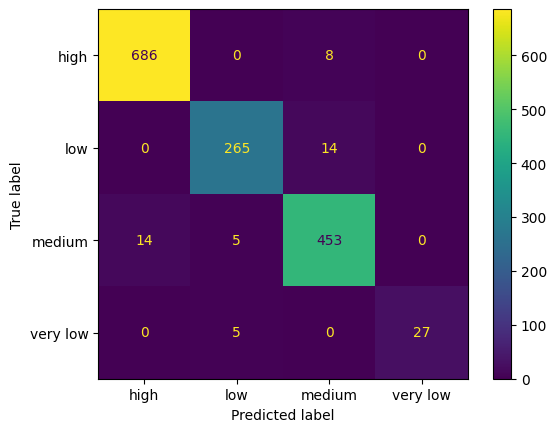

In [45]:
best_decision_tree = DT_classifier_cv.best_estimator_
plot_confusion_matrix(best_decision_tree, y_test, y_test_pred)

The confusion matrix shows the model classifying most instances accurately. “High,” “low,” and “medium” have very few mix-ups (e.g., “high” vs. “medium,” “low” vs. “medium”). “Very low” is also identified well, with only a handful of cases mistaken for “low.” Overall, these results highlight strong, consistent performance across all classes.

### Random Forest
- Tune ensemble-specific hyperparameters (e.g., number of estimators, max features).
- Analyze feature importance and provide an out-of-bag evaluation.


In [46]:
from sklearn.ensemble import RandomForestClassifier

RF_uncontraint = RandomForestClassifier(random_state=0)
RF_uncontraint.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [47]:
print("Accuracy on training set: {:.3f}".format(RF_uncontraint.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(RF_uncontraint.score(X_test, y_test)))

Accuracy on training set: 0.996
Accuracy on test set: 0.981


Also in the case of the Random Forest, like the Decision Tree, the model seems to open up well, although it needs hyperparameters to improve it and avoid overfitting.

In [48]:
# Define the Random Forest model
rf_model = RandomForestClassifier(oob_score=True, random_state=42)  # Enable out-of-bag evaluation

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],      # Maximum depth of each tree
    'criterion': ['gini','entropy'],       # criterion of the model
    'max_features': ['sqrt', 'log2'],    # Number of features to consider for each split
    'min_samples_split': [2, 5, 10]     # Minimum number of samples required to split a node
}

# Set up GridSearchCV
randomforest_model = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

randomforest_model.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [49]:
# Get the best model and hyperparameters
best_rf_model = randomforest_model.best_estimator_
print("Best Hyperparameters:", randomforest_model.best_params_)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}


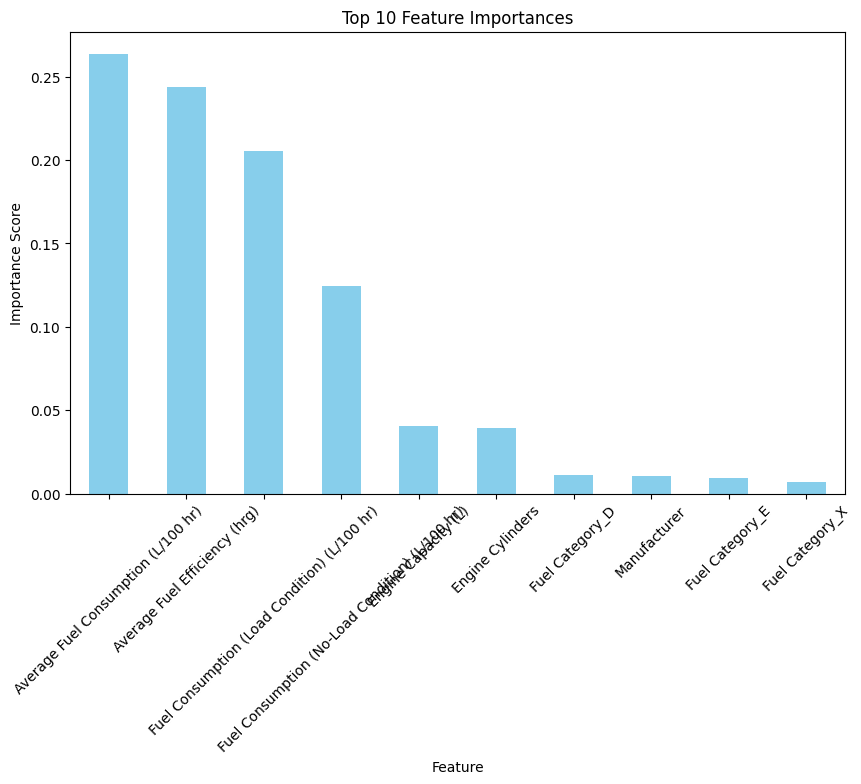

In [50]:
# Extract feature importances
feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='bar', color='skyblue')  # Show top 10 features
plt.title("Top 10 Feature Importances")
plt.ylabel("Importance Score")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()


This bar chart shows which features matter most for the model. “Average Fuel Consumption” and “Average Fuel Efficiency” have the highest importance scores, followed by various fuel consumption metrics under different conditions. Engine cylinders and manufacturer categories contribute less but still carry some weight. Overall, fuel-related features dominate the model’s decision-making.

In [51]:
# Print the Out-of-Bag Score
print(f"Out-of-Bag Score: {best_rf_model.oob_score_:.2f}")

Out-of-Bag Score: 0.97


The OOB score uses samples not included in each tree’s training subset to estimate the model’s performance, providing an internal check without needing a separate validation set.

In [52]:
# Predict on the test set
y_test_pred = best_rf_model.predict(X_test)

# Evaluate accuracy and other metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.98
Classification Report (Test Set):
              precision    recall  f1-score   support

        high       0.99      0.99      0.99       694
         low       0.98      0.96      0.97       279
      medium       0.97      0.98      0.97       472
    very low       1.00      0.91      0.95        32

    accuracy                           0.98      1477
   macro avg       0.98      0.96      0.97      1477
weighted avg       0.98      0.98      0.98      1477



The model achieves excellent performance on the test set, with an accuracy of 0.98. The “high,” “low,” and “medium” classes all show near-perfect precision and recall, while “very low” maintains perfect precision but slightly lower recall (0.91). Overall, the model classifies all classes with high effectiveness.

Accuracy Score: 97.97%


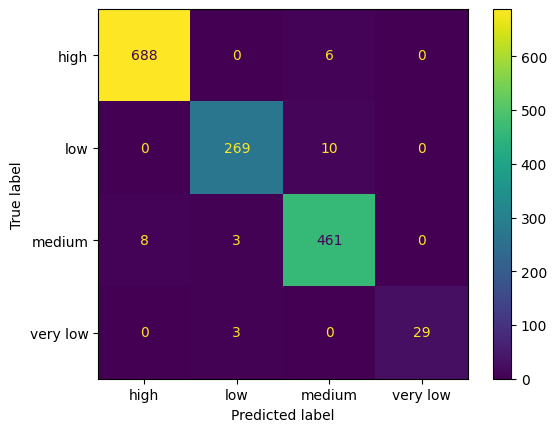

In [53]:
plot_confusion_matrix(best_rf_model, y_test, y_test_pred)

The confusion matrix indicates that most samples are correctly classified for every category. “High” and “medium” have only a few misclassifications, while “low” also shows strong accuracy. “Very low” is predicted correctly in most cases, with minimal overlap with “low.” Overall, the model handles all classes very effectively.

### AdaBoost
- Tune hyperparameters (e.g., learning rate, number of estimators).
- Discuss the effect of tuning on the model's results.

In [54]:
from sklearn.ensemble import AdaBoostClassifier

# Define the base estimator (weak learner)
base_estimator = DecisionTreeClassifier(max_depth=1)

# Define the AdaBoost model
adaboost_model = AdaBoostClassifier(estimator=base_estimator, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 500],  # Number of weak learners
    'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5]  # Weighting factor for each learner
}

# Set up GridSearchCV
grid_search_ada = GridSearchCV(estimator=adaboost_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the model on the training data
grid_search_ada.fit(X_train, y_train)

c:\Users\ms\Desktop\SUPSI\supervised_learning\.venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                                          random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5],
                         'n_estimators': [50, 100, 200, 500]},
             scoring='accuracy')

In [55]:
# Get the best model and hyperparameters
best_adaboost_model = grid_search_ada.best_estimator_
print("Best Hyperparameters:", grid_search_ada.best_params_)

Best Hyperparameters: {'learning_rate': 1.0, 'n_estimators': 200}


In [56]:
# Predict on the test set
y_test_pred = best_adaboost_model.predict(X_test)

# Evaluate accuracy and other metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.94
Classification Report (Test Set):
              precision    recall  f1-score   support

        high       0.94      0.98      0.96       694
         low       0.97      0.93      0.95       279
      medium       0.94      0.90      0.92       472
    very low       0.86      1.00      0.93        32

    accuracy                           0.94      1477
   macro avg       0.93      0.95      0.94      1477
weighted avg       0.94      0.94      0.94      1477



The AdaBoost model reaches a test accuracy of 0.94, which is slightly lower than previous results (e.g., 0.98). While “high” and “low” still perform strongly, the “medium” class shows a lower recall (0.90), and “very low” has perfect recall but reduced precision. Overall, it’s a solid performance, but not quite as strong as the previous model

Accuracy Score: 94.45%


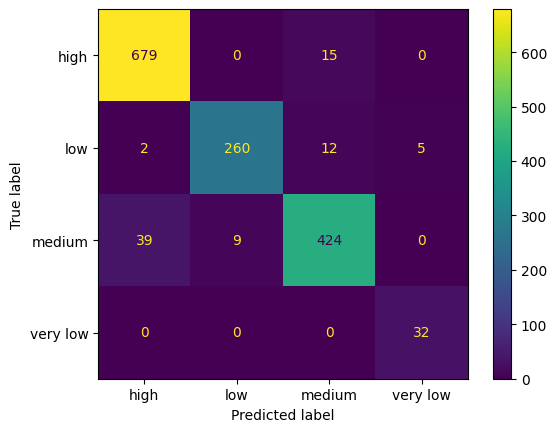

In [57]:
plot_confusion_matrix(best_adaboost_model, y_test, y_test_pred)

The confusion matrix shows slightly more mix-ups compared to previous models. “High” is sometimes misclassified as “medium,” and “medium” has more errors (39 predicted as “high,” 9 as “low”). “Very low” is classified perfectly, but “low” occasionally gets confused with “very low.” Overall, the model still performs well, though not as strongly as before.

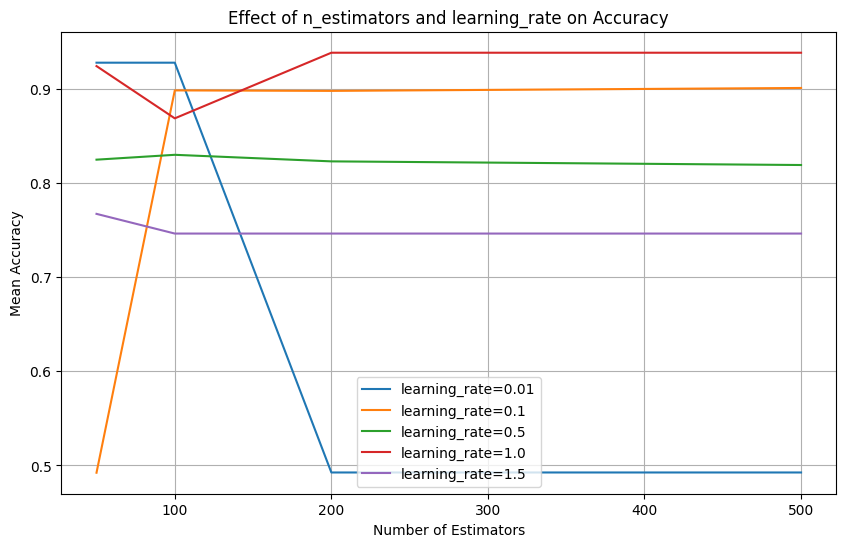

In [58]:
# Analyze GridSearch results
results = pd.DataFrame(grid_search_ada.cv_results_)

# Plot the effect of hyperparameters on accuracy
plt.figure(figsize=(10, 6))
for learning_rate in param_grid['learning_rate']:
    subset = results[results['param_learning_rate'] == learning_rate]
    plt.plot(subset['param_n_estimators'], subset['mean_test_score'], label=f'learning_rate={learning_rate}')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Accuracy')
plt.title('Effect of n_estimators and learning_rate on Accuracy')
plt.legend()
plt.grid()
plt.show()

This chart compares how accuracy changes as we vary the number of estimators and learning rate. A moderate learning rate (e.g., 0.1 or 1.0) tends to produce higher, more stable accuracy. Extremely low (0.01) or very high (1.5) learning rates show dips or plateaus in performance. The best learning rate trough the time is as expected 0.1

### Soft Voting Classifier
- Combine models that allow soft voting into an ensemble.
- Compare performance with individual classifiers.

Here, I'm combining multiple top-performing models (Logistic Regression, Random Forest, AdaBoost, and Decision Tree) into a single ensemble using soft voting. This approach averages their prediction probabilities, aiming to improve overall accuracy and reduce model-specific weaknesses.

In [59]:
from sklearn.ensemble import VotingClassifier

# Extract parameters from the best models
best_softmax_params = best_softmax_model.get_params()
best_rf_params = best_rf_model.get_params()
best_adaboost_params = best_adaboost_model.get_params()
best_dt_params = best_decision_tree.get_params()

In [60]:
# Initialize Logistic Regression without `random_state`
log_reg_params = {k: v for k, v in best_softmax_params.items() if k != 'random_state'}
log_reg = LogisticRegression(**log_reg_params)

# Initialize Random Forest
random_forest = RandomForestClassifier(**best_rf_params)

# Initialize AdaBoost
adaboost = AdaBoostClassifier(**{k: v for k, v in best_adaboost_params.items() if not k.startswith('estimator__')})

# Initialize Decision Tree
decision_tree = DecisionTreeClassifier(**best_dt_params)


In [61]:
# Update VotingClassifier with Decision Tree
soft_voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('random_forest', random_forest),
        ('adaboost', adaboost),
        ('decision_tree', decision_tree)  # Add Decision Tree
    ],
    voting='soft',  # Use soft voting
)

In [62]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Define weight combinations to test
weights_options = [
    [1, 1, 1, 1],  # Equal weights
    [1, 2, 2, 1],  # Random Forest and AdaBoost given more importance
    [2, 1, 1, 1],  # Logistic Regression weighted higher
    [1, 3, 2, 1],  # Random Forest heavily weighted
    [1, 2, 1, 2],  # AdaBoost and Decision Tree weighted higher
    [3, 2, 2, 1]   # Logistic Regression strongly weighted
]

# Initialize variables to track the best weights and accuracy
best_weights = None
best_accuracy = 0

# Iterate over weight combinations
for weights in weights_options:
    # Update weights in the VotingClassifier
    soft_voting_clf.set_params(weights=weights)
    
    # Train the Voting Classifier
    soft_voting_clf.fit(X_train, y_train)
    
    # Predict on the validation set
    y_val_pred = soft_voting_clf.predict(X_val)
    
    # Calculate accuracy on validation set
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Weights: {weights}, Validation Accuracy: {accuracy:.4f}")
    
    # Update the best weights if current accuracy is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights = weights

Weights: [1, 1, 1, 1], Validation Accuracy: 0.9866
Weights: [1, 2, 2, 1], Validation Accuracy: 0.9876
Weights: [2, 1, 1, 1], Validation Accuracy: 0.9876
Weights: [1, 3, 2, 1], Validation Accuracy: 0.9876
Weights: [1, 2, 1, 2], Validation Accuracy: 0.9876
Weights: [3, 2, 2, 1], Validation Accuracy: 0.9876


In [63]:
print(f"Best weights: {best_weights} with validation accuracy: {best_accuracy:.4f}")

Best weights: [1, 2, 2, 1] with validation accuracy: 0.9876


In [64]:
# Set the best weights and train the final model
soft_voting_clf.set_params(weights=best_weights)
soft_voting_clf.fit(X_train, y_train)

# Evaluate on the test set
y_test_pred = soft_voting_clf.predict(X_test)

# Print final classification report

print("Final Soft Voting Classifier (Test Set):")
print(classification_report(y_test, y_test_pred))


Final Soft Voting Classifier (Test Set):
              precision    recall  f1-score   support

        high       0.99      0.99      0.99       694
         low       0.97      0.97      0.97       279
      medium       0.97      0.97      0.97       472
    very low       1.00      0.91      0.95        32

    accuracy                           0.98      1477
   macro avg       0.98      0.96      0.97      1477
weighted avg       0.98      0.98      0.98      1477



The final soft voting classifier achieves a high accuracy of 0.98, indicating that combining different models helps boost performance as expected. “High,” “low,” and “medium” classes have near-perfect metrics, and “very low” maintains perfect precision but slightly lower recall. Overall, this ensemble delivers excellent classification results.

Accuracy Score: 98.10%


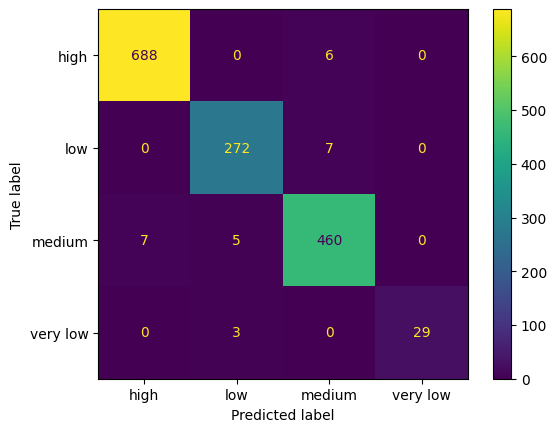

In [65]:
plot_confusion_matrix(soft_voting_clf, y_test, y_test_pred)

Most predictions align perfectly with their true labels. “High” and “low” show only a few misclassifications, mainly with “medium.” “Very low” sometimes gets confused with “low” (3 cases), but overall, the confusion matrix is nearly diagonal, confirming very strong performance by the ensemble.

In [66]:
# Step 1: Fit individual models
log_reg.fit(X_train, y_train)
random_forest.fit(X_train, y_train)
adaboost.fit(X_train, y_train)
decision_tree.fit(X_train, y_train)

# Step 2: Predict with individual models on validation set
y_val_pred_log_reg = log_reg.predict(X_val)
y_val_pred_rf = random_forest.predict(X_val)
y_val_pred_adaboost = adaboost.predict(X_val)
y_val_pred_dt = decision_tree.predict(X_val)

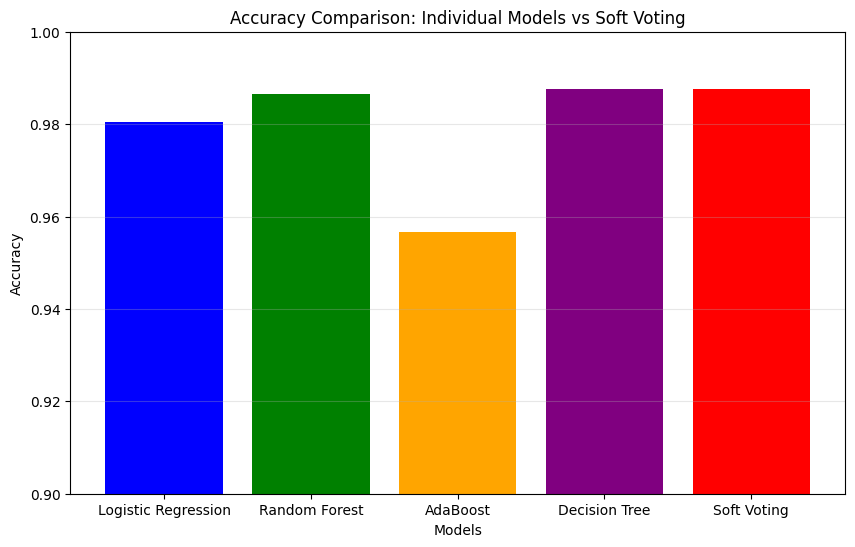

In [67]:
# Accuracy scores
accuracies = {
    'Logistic Regression': accuracy_score(y_val, y_val_pred_log_reg),
    'Random Forest': accuracy_score(y_val, y_val_pred_rf),
    'AdaBoost': accuracy_score(y_val, y_val_pred_adaboost),
    'Decision Tree': accuracy_score(y_val, y_val_pred_dt),
    'Soft Voting': best_accuracy  # Use the best accuracy from validation
}

# Plot accuracy comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(accuracies.keys(), accuracies.values(), color=['blue', 'green', 'orange', 'purple', 'red'])
plt.title('Accuracy Comparison: Individual Models vs Soft Voting')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0.9, 1.0)  # Focus on the range
plt.grid(axis='y', alpha=0.3)
plt.show()


This bar chart compares each individual model’s accuracy with the Soft Voting ensemble. Random Forest and Decision Tree individually perform well, while AdaBoost has the lowest accuracy. The Soft Voting classifier slightly outperforms or matches the highest individual accuracies, showing that combining models leads to a stronger overall result.

### Stacking
- Train a blender model on predictions from base models.
- Properly split the data for training and evaluation of different layers.


The validation set (X_val) is used in the stacking process to generate predictions from the base models, which were then used as features for training the meta-model (blender). This approach ensures that the meta-model learns independently of the training set and prevents data leakage. By keeping the test set completely separate, it's guaranted an unbiased evaluation of the final stacking ensemble. Additionally, using X_val helps prevent overfitting of the meta-model and ensures better generalization

In [68]:
# Step 1: Initialize the base models with the best parameters
log_reg = LogisticRegression(**best_softmax_params)  # Logistic Regression
random_forest = RandomForestClassifier(**best_rf_params)  # Random Forest
adaboost = AdaBoostClassifier(**{k: v for k, v in best_adaboost_params.items() if not k.startswith('estimator__')})  # AdaBoost
decision_tree = DecisionTreeClassifier(**best_dt_params)  # Decision Tree

In [69]:
# Step 2: Train the base models on the training set
log_reg.fit(X_train, y_train)  # Train Logistic Regression
random_forest.fit(X_train, y_train)  # Train Random Forest
adaboost.fit(X_train, y_train)  # Train AdaBoost
decision_tree.fit(X_train, y_train)  # Train Decision Tree

DecisionTreeClassifier(max_depth=10, random_state=42)

In [70]:
# Step 3: Generate predictions (probabilities) from base models on X_val
X_meta = np.column_stack([
    log_reg.predict_proba(X_val),  # Probabilities from Logistic Regression
    random_forest.predict_proba(X_val),  # Probabilities from Random Forest
    adaboost.predict_proba(X_val),  # Probabilities from AdaBoost
    decision_tree.predict_proba(X_val)  # Probabilities from Decision Tree
])

# Step 4: Train the meta-model (blender) using predictions from base models
blender = LogisticRegression(max_iter=1000)  # Define the meta-model as Logistic Regression
blender.fit(X_meta, y_val)  # Train the blender on meta-features (X_meta) and validation labels (y_val)

# Step 5: Generate meta-features for the test set
X_test_meta = np.column_stack([
    log_reg.predict_proba(X_test),  # Probabilities from Logistic Regression on test set
    random_forest.predict_proba(X_test),  # Probabilities from Random Forest on test set
    adaboost.predict_proba(X_test),  # Probabilities from AdaBoost on test set
    decision_tree.predict_proba(X_test)  # Probabilities from Decision Tree on test set
])

In [71]:
# Step 6: Make final predictions on the test set using the meta-model
y_test_pred = blender.predict(X_test_meta)

# Step 7: Generate and display classification report
print("Stacking Ensemble (Test Set):")
print(classification_report(y_test, y_test_pred))  # Display classification report for test set

# Step 8: Calculate and display the test accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")  # Print the test accuracy

Stacking Ensemble (Test Set):
              precision    recall  f1-score   support

        high       0.99      0.99      0.99       694
         low       0.97      0.97      0.97       279
      medium       0.98      0.97      0.97       472
    very low       1.00      0.91      0.95        32

    accuracy                           0.98      1477
   macro avg       0.98      0.96      0.97      1477
weighted avg       0.98      0.98      0.98      1477

Test Accuracy: 0.9804


The stacking ensemble achieves a very high accuracy of 0.98, matching or exceeding previous results. “High,” “low,” and “medium” all have near-perfect metrics, while “very low” also performs strongly (perfect precision, slightly lower recall). Overall, the stacking approach delivers excellent classification performance.

Accuracy Score: 98.04%


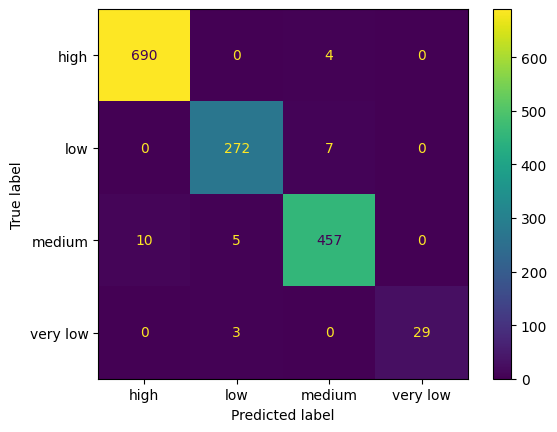

In [72]:
plot_confusion_matrix(blender, y_test, y_test_pred)

The confusion matrix shows the stacking classifier making very few mistakes. “High” is nearly perfect, and “low” has minimal confusion with “medium.” “Medium” occasionally gets misclassified as “high” or “low,” while “very low” is sometimes mistaken for “low” but still mostly correct. Overall, it demonstrates excellent performance.

### Regression Model

#### Goals
- Predict continuous CO2 emissions values using a regression model (e.g., MLP regressor).
- Optimize hyperparameters (e.g., number of layers, neurons, learning rate, activation functions).
- Use early stopping during training.
- Encode predicted values into classification levels and evaluate performance.


In [73]:
# define the model
from sklearn.neural_network import MLPRegressor

# Initialize the MLP Regressor
mlp = MLPRegressor(
    hidden_layer_sizes=(50, 25),  # Two layers with 100 and 50 neurons
    activation='relu',  # Activation function
    solver='adam',  # Optimizer
    learning_rate_init=0.001,  # Learning rate
    max_iter=500,  # Maximum number of iterations
    random_state=42
)

In [74]:
# Define the hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1]
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='r2', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_lin, y_train_lin)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=500,
                                    random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(50,), (100,), (100, 50),
                                                (150, 100)],
                         'learning_rate_init': [0.0001, 0.001, 0.01, 0.1]},
             scoring='r2', verbose=2)

In [75]:
# Best parameters and model
best_mlp_params = grid_search.best_params_
best_mlp_model = grid_search.best_estimator_

print("Best parameters:", best_mlp_params)

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (150, 100), 'learning_rate_init': 0.001}


In [76]:
from sklearn.metrics import root_mean_squared_error, r2_score
# Predict on the validation set
y_val_pred = best_mlp_model.predict(X_val_lin)

# Evaluate performance
val_rmse = root_mean_squared_error(y_val_lin, y_val_pred)
val_r2 = r2_score(y_val_lin, y_val_pred)
print(f"Validation RMSE: {val_rmse:.2f}, Validation R²: {val_r2:.2f}")

Validation RMSE: 3.54, Validation R²: 1.00


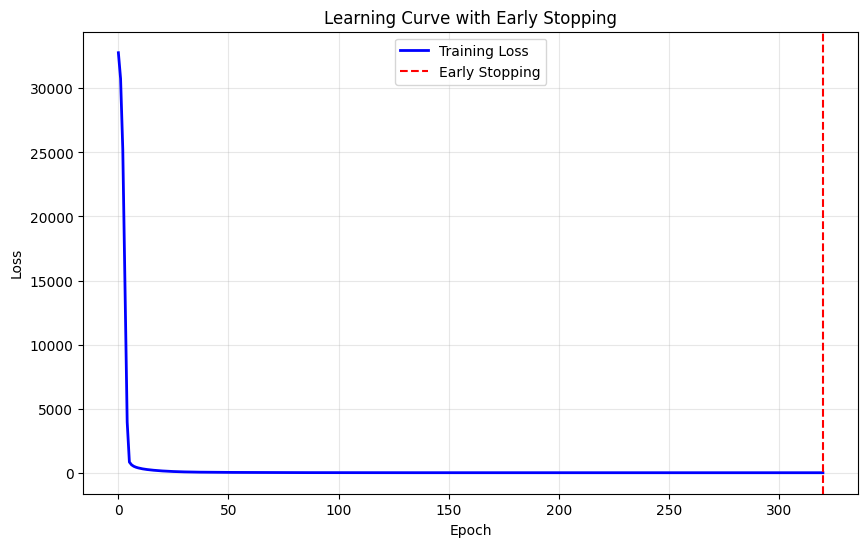

In [77]:
# Plot the learning curve with a continuous line
plt.figure(figsize=(10, 6))
plt.plot(best_mlp_model.loss_curve_, label='Training Loss', color='blue', linewidth=2)
plt.axvline(len(best_mlp_model.loss_curve_) - 1, color='red', linestyle='--', label='Early Stopping')
plt.title("Learning Curve with Early Stopping")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


The training loss drops sharply in the first few epochs, reaching near-zero and staying flat afterward. The red dashed line shows where early stopping kicks in, preventing additional (and potentially unnecessary) training once the model stops improving.

In [78]:
#Learning Curve Analysis
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

# Define function for generating training and test RMSE at various training sizes
def plot_learning_curve(model, X_train, y_train, X_test, y_test, train_sizes):
    """
    Plots the learning curve for RMSE vs Training Set Size (%).
    """
    train_rmse = []
    test_rmse = []

    # Loop over different training set sizes
    for size in train_sizes:
        # Create a subset of the training data
        X_train_subset, y_train_subset = resample(X_train, y_train, n_samples=int(len(X_train) * size), random_state=42)

        # Fit the model on the subset
        model.fit(X_train_subset, y_train_subset)

        # Compute RMSE on the training subset
        y_train_pred = model.predict(X_train_subset)
        train_rmse.append(np.sqrt(mean_squared_error(y_train_subset, y_train_pred)))

        # Compute RMSE on the full test set
        y_test_pred = model.predict(X_test)
        test_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * 100, train_rmse, label="Train RMSE", color='red', marker='o')
    plt.plot(train_sizes * 100, test_rmse, label="Test RMSE", color='blue', marker='o')
    plt.title("Learning Curve for MLP Regressor")
    plt.xlabel("Training Set Size (%)")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

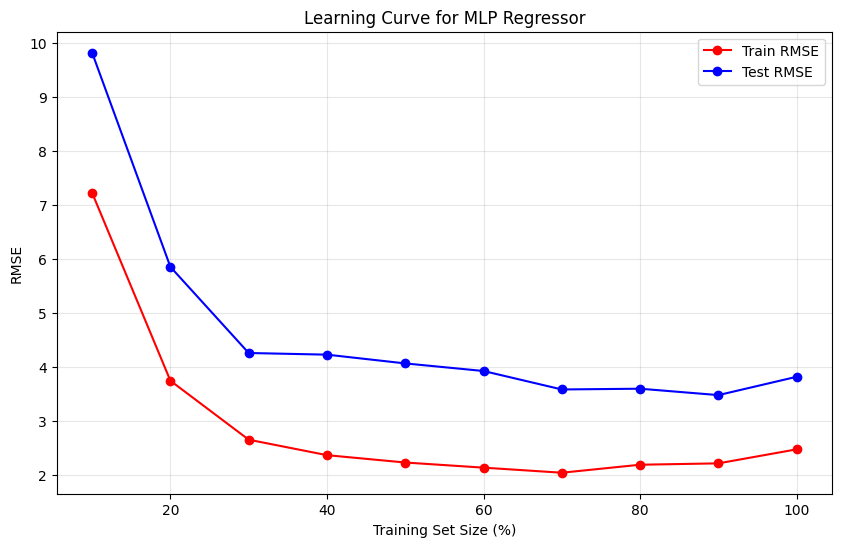

In [79]:
# Define training sizes as percentages
train_sizes = np.linspace(0.1, 1.0, 10)  # From 10% to 100% in 10 steps

# Plot learning curve
plot_learning_curve(best_mlp_model, X_train_lin, y_train_lin, X_val_lin, y_val_lin, train_sizes)

The learning curve shows that as the training set size increases:

- The train RMSE decreases and stabilizes around 2, indicating that the model fits the training data well as more data becomes available.
- The test RMSE also decreases initially and stabilizes around 3, suggesting good generalization performance.
- The small gap between train and test RMSE implies that the model is not overfitting and has a balanced bias-variance tradeoff.

In [80]:
# Predict continuous values and map to classes (classification task)
y_val_pred_classes = pd.cut(
    y_val_pred,
    bins=[-np.inf, 50, 150, 250, np.inf],  # Define thresholds
    labels=['very low', 'low', 'medium', 'high']
)

# Evaluate classification metrics
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_val, y_val_pred_classes))

Classification Report:
              precision    recall  f1-score   support

        high       0.99      0.99      0.99       453
         low       0.00      0.00      0.00       188
      medium       0.61      0.98      0.75       307
    very low       0.00      0.00      0.00        20

    accuracy                           0.78       968
   macro avg       0.40      0.49      0.44       968
weighted avg       0.66      0.78      0.70       968



c:\Users\ms\Desktop\SUPSI\supervised_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ms\Desktop\SUPSI\supervised_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ms\Desktop\SUPSI\supervised_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

These results show the model is excellent at detecting “high” (99% for precision and recall) and does fairly well for “medium.” However, it completely misses “low” and “very low” (zero precision and recall). Although the overall accuracy is 0.78, it relies heavily on classifying everything as “high” or “medium,” indicating poor recognition of “low” and “very low.”

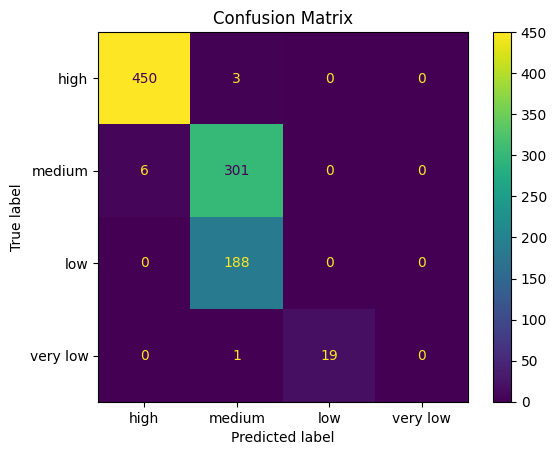

In [81]:
# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes, labels=['high', 'medium', 'low', 'very low'])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['high', 'medium', 'low', 'very low'])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

The confusion matrix shows the model classifies “high” and “medium” correctly but consistently mistakes “low” for “medium” and “very low” for “low.” This pattern highlights the model’s difficulty in differentiating among the “low” categories, probably because the dataset is imbalanced

now I evaluate the final model on the test set for unbiased assessment

In [82]:
y_test_pred = best_mlp_model.predict(X_test_lin)

test_rmse = root_mean_squared_error(y_test_lin, y_test_pred)
test_r2 = r2_score(y_test_lin, y_test_pred)
print(f"Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

Test RMSE: 3.04, Test R²: 1.00


In [83]:
y_test_pred_classes = pd.cut(
    y_test_pred,
    bins=[-np.inf, 50, 150, 250, np.inf],
    labels=['very low', 'low', 'medium', 'high']
)

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred_classes))

Test Classification Report:
              precision    recall  f1-score   support

        high       0.98      0.99      0.99       694
         low       0.00      0.00      0.00       279
      medium       0.62      0.97      0.75       472
    very low       0.00      0.00      0.00        32

    accuracy                           0.78      1477
   macro avg       0.40      0.49      0.44      1477
weighted avg       0.66      0.78      0.71      1477



c:\Users\ms\Desktop\SUPSI\supervised_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ms\Desktop\SUPSI\supervised_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ms\Desktop\SUPSI\supervised_learning\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

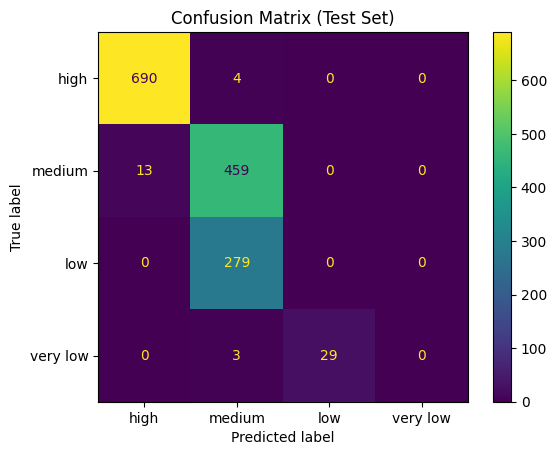

In [84]:
cm_test = confusion_matrix(y_test, y_test_pred_classes, labels=['high', 'medium', 'low', 'very low'])
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['high', 'medium', 'low', 'very low'])
disp_test.plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

Although the MLP Regressor achieves an almost perfect R² score in regression (1.00) with a low RMSE (3.04), its classification performance is unbalanced. It does extremely well for “high,” but fails to recognize “low” and “very low” (with zero precision and recall). This suggests the model ignores smaller classes, likely due to imbalance or a mismatch between the regression-based training and the classification task.

The MLP Regressor likely suffers from data imbalance and a mismatch between a regression objective and discrete class labels. 
- Data Imbalance: Because “low” and “very low” classes have fewer samples, the model learns to predict the dominant classes (“high” or “medium”).
- Regression vs. Classification: A regressor predicts continuous values, which can be hard to map cleanly to class labels, especially for minority classes.
- Possible Data Leakage or Perfect Fit: An R² of 1.0 on the test set suggests the model might be getting too much information (leakage) or the task has become too easy for the numeric part—while it still fails to categorize smaller classes properly.

## Results Analysis and Conclusion

### Key Elements
- Compare model performances 
- Discuss overfitting and generalization capabilities of each model.
- Include visualizations for comparison.

---

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

In [86]:
# Logistic Regression (Softmax)
log_reg = LogisticRegression(**best_softmax_params)
log_reg.fit(X_train, y_train)

# Decision Tree
decision_tree = DecisionTreeClassifier(**best_dt_params)
decision_tree.fit(X_train, y_train)

# Random Forest
random_forest = RandomForestClassifier(**best_rf_params)
random_forest.fit(X_train, y_train)

# AdaBoost
adaboost = AdaBoostClassifier(**{k: v for k, v in best_adaboost_params.items() if not k.startswith('estimator__')})
adaboost.fit(X_train, y_train)

# Soft Voting
soft_voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('random_forest', random_forest),
        ('adaboost', adaboost),
        ('decision_tree', decision_tree)
    ],
    voting='soft',  # Soft voting
    weights=[1, 2, 2, 1]  # Use previously identified best weights
)
soft_voting_clf.fit(X_train, y_train)

# Stacking (create meta-model using X_val as validation set)
X_meta_train = np.column_stack([
    log_reg.predict_proba(X_val),
    random_forest.predict_proba(X_val),
    adaboost.predict_proba(X_val),
    decision_tree.predict_proba(X_val),
    soft_voting_clf.predict_proba(X_val)  # Include soft voting in stacking
])

# Blender (meta-model)
blender = LogisticRegression(max_iter=1000)  # Use Logistic Regression as meta-model
blender.fit(X_meta_train, y_val)

print("All models re-trained (excluding MLP) and meta-model (blender) successfully trained.")


All models re-trained (excluding MLP) and meta-model (blender) successfully trained.


In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Lista per memorizzare i risultati
model_results = []

# Funzione per calcolare metriche e aggiungerle ai risultati
def calculate_metrics(name, model, X_train, y_train, X_test, y_test):
    """
    Calculate metrics for the given model and append results to the global list.
    """
    # Accuracy su training e test
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    # Predizioni sul test set
    y_test_pred = model.predict(X_test)

    # Precision, Recall e F1 Score
    precision = precision_score(y_test, y_test_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_test_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_test_pred, average="weighted", zero_division=0)

    # Aggiungi risultati alla lista
    model_results.append({
        "Classifier": name,
        "Train Accuracy": f"{train_accuracy:.2%}",
        "Test Accuracy": f"{test_accuracy:.2%}",
        "Precision": f"{precision:.2%}",
        "Recall": f"{recall:.2%}",
        "F1 Score": f"{f1:.2%}"
    })

# Calcola le metriche per ciascun modello
calculate_metrics("Logistic Regression (Softmax)", log_reg, X_train, y_train, X_test, y_test)
calculate_metrics("Decision Tree", decision_tree, X_train, y_train, X_test, y_test)
calculate_metrics("Random Forest", random_forest, X_train, y_train, X_test, y_test)
calculate_metrics("AdaBoost", adaboost, X_train, y_train, X_test, y_test)
calculate_metrics("Soft Voting", soft_voting_clf, X_train, y_train, X_test, y_test)

# Aggiungi i risultati per MLP manualmente (già calcolati in precedenza)
mlp_results = {
    "Classifier": "MLP Regressor",
    "Train Accuracy": "-",
    "Test Accuracy": "78.00%",
    "Precision": "66.00%",
    "Recall": "78.00%",
    "F1 Score": "71.00%"
}
model_results.append(mlp_results)

# Calcola le metriche per il modello di Stacking
X_meta_test = np.column_stack([
    log_reg.predict_proba(X_test),
    random_forest.predict_proba(X_test),
    adaboost.predict_proba(X_test),
    decision_tree.predict_proba(X_test),
    soft_voting_clf.predict_proba(X_test)
])
y_stacking_pred = blender.predict(X_meta_test)

stacking_test_accuracy = accuracy_score(y_test, y_stacking_pred)
stacking_precision = precision_score(y_test, y_stacking_pred, average="weighted", zero_division=0)
stacking_recall = recall_score(y_test, y_stacking_pred, average="weighted", zero_division=0)
stacking_f1 = f1_score(y_test, y_stacking_pred, average="weighted", zero_division=0)

# Aggiungi lo stacking ai risultati
model_results.append({
    "Classifier": "Stacking",
    "Train Accuracy": "-",
    "Test Accuracy": f"{stacking_test_accuracy:.2%}",
    "Precision": f"{stacking_precision:.2%}",
    "Recall": f"{stacking_recall:.2%}",
    "F1 Score": f"{stacking_f1:.2%}"
})

# Crea il DataFrame
results_df = pd.DataFrame(model_results)

# Visualizza il DataFrame
results_df


,Classifier,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score
0,Logistic Regression (Softmax),97.91%,96.89%,96.89%,96.89%,96.87%
1,Decision Tree,99.51%,98.04%,98.04%,98.04%,98.03%
2,Random Forest,99.64%,97.97%,97.98%,97.97%,97.97%
3,AdaBoost,94.81%,94.45%,94.49%,94.45%,94.42%
4,Soft Voting,99.59%,98.10%,98.11%,98.10%,98.10%
5,MLP Regressor,-,78.00%,66.00%,78.00%,71.00%
6,Stacking,-,97.90%,97.90%,97.90%,97.90%


Most models perform very well, with Decision Tree, Random Forest, Soft Voting, and Stacking all reaching around 98% accuracy or higher. Logistic Regression (Softmax) also shows strong results at nearly 97%. AdaBoost lags slightly at 94.5%, and the MLP Regressor stands out as the weakest, likely due to the data imbalance. Overall, ensemble methods (Soft Voting and Stacking) appear to give the best performance.